In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pylab as plt

%load_ext rpy2.ipython
import pandas as pd
import numpy as np

import os
os.chdir("/Users/lucapozzi/repos/Arlem/")

## Copula

In [2]:
from harlem.data.harlem_copula import HarlemCopula

In [3]:
copula_distribution=HarlemCopula()

x = np.array([[0.5, 0.5], [0.5, 0.1], [0.1, 0.5]])

In [4]:
[copula_distribution.pdf(i) for i in x]

[0.07309495575921103, 0.0001073643912766637, 4.015184103472168e-14]

In [5]:
%%R
library(copula)
copula= frankCopula(-5)
margins=c("beta", "beta")
paramMargins=list(list(shape1 = 20, shape2 =5),
                  list(shape1=5,shape2=7))

simCop <- mvdc(copula, margins, paramMargins)


sapply(list(c(0.5, 0.5), c(0.5, 0.1), c(0.1, 0.5)), function(x) dMvdc(x, simCop))



[1] 7.309496e-02 1.073644e-04 4.015184e-14


In [6]:
[copula_distribution.cdf(i) for i in x]

[0.0001921193027833871, 7.266588121196603e-08, 0.0]

In [7]:
%%R
sapply(list(c(0.5, 0.5), c(0.5, 0.1), c(0.1, 0.5)), function(x) pMvdc(x, simCop))

[1] 1.921193e-04 7.266588e-08 0.000000e+00


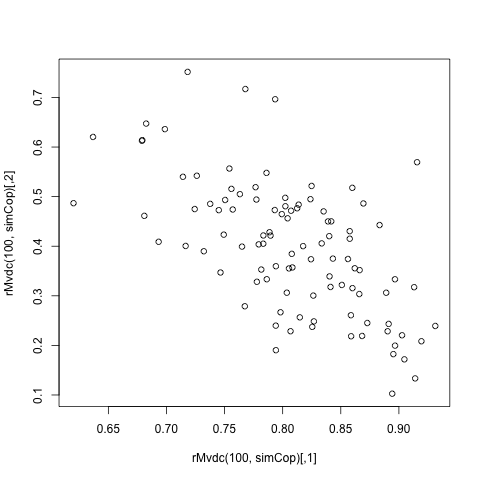

In [8]:
%%R
plot(rMvdc(100, simCop))

In [10]:
sample = copula_distribution.rvs(100)

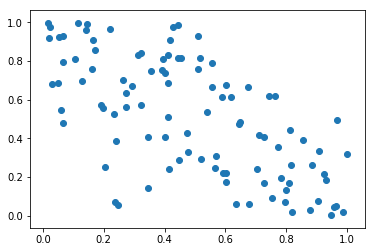

In [11]:
plt.scatter(sample[0,:], sample[1,:])

In [12]:
copula_distribution.cdf(0.5, 1)

0.7255859375

In [13]:
copula_distribution.pdf(0.5, 1)

2.2558593750000018

## Test Simpson

In [ ]:
from harlem.utils import SQRT_DBL_EPSILON, quick_simpson

## Survival

In [22]:
from lifelines import KaplanMeierFitter
from statsmodels.distributions.empirical_distribution import StepFunction

In [16]:
from lifelines.datasets import load_waltons
df = load_waltons() # returns a Pandas DataFrame

print(df.head())

      T  E    group
0   6.0  1  miR-137
1  13.0  1  miR-137
2  13.0  1  miR-137
3  13.0  1  miR-137
4  19.0  1  miR-137


In [23]:
kmf = KaplanMeierFitter()
kmf.fit(df['T'], event_observed=df['E']) 
surv_fun = StepFunction(kmf.survival_function_.index,
                        kmf.survival_function_['KM_estimate'],
                        sorted=True, side='right')

In [18]:
kmf.survival_function_.head()

,KM_estimate
timeline,
0.0,1.000000
6.0,0.993865
7.0,0.987730
9.0,0.969210
13.0,0.950690


In [26]:
surv_fun(8)

0.9877300613496934

In [52]:
from harlem.data.data_generator import DataGeneratorHarlem
from harlem.parameters.init_Q import get_survival_function

In [53]:
%%capture
data_gen = DataGeneratorHarlem()

In [54]:
full_data, _ = data_gen.data_generator(5000)

seed: 1544320648


In [55]:
full_data.delta0.dtype

dtype('int64')

In [56]:
%%R -i full_data
dim(full_data)

/anaconda3/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)


[1] 5000    5


In [57]:
%%R -i full_data
library(survival)
QcFit<-survfit(Surv(full_data$v-full_data$w,1-full_data$delta1)~1)
Qc<-stepfun(QcFit$time,c(1,QcFit$surv),f=0)
Snfit<-survfit(Surv(full_data$w,full_data$v,full_data$delta1)~1)
Sn<-stepfun(Snfit$time,c(1,Snfit$surv),f=0)

In [58]:
Qc = get_survival_function(time=full_data.v - full_data.w,
                               event=1 - full_data.delta1)

Sn = get_survival_function(time=full_data.v,
                           event=full_data.delta1,
                           entry=full_data.w)


In [65]:
%R Qc(60)

array([0.3047387])

In [66]:
Qc(60)

0.3047387027060009

In [62]:
%R Sn(50)

array([0.51804361])

In [67]:
Sn(50)

0.5180436091466609

In [71]:
%%R 
dGn<-1/Sn(full_data$w); 
dGn[Sn(full_data$w)==0] <- 0
dGn[dGn/sum(dGn)>100/nrow(full_data)] <- 0
dGn<-dGn/sum(dGn)
dGn[1:10]

 [1] 0.0001357317 0.0001460318 0.0001947486 0.0001468394 0.0003054812
 [6] 0.0001269464 0.0004237710 0.0001559500 0.0022566990 0.0001411263


In [72]:
dGn = 1 / Sn(full_data.w)
dGn[Sn(full_data.w) == 0] = 0
dGn[dGn / sum(dGn) > 100 / full_data.shape[0]] = 0
dGn = dGn / sum(dGn)
dGn[:10]

array([0.00013573, 0.00014603, 0.00019475, 0.00014684, 0.00030548,
       0.00012695, 0.00042377, 0.00015595, 0.0022567 , 0.00014113])

In [49]:
step_fun = StepFunction(kmf.survival_function_.index, 
             kmf.survival_function_['KM_estimate'],
             sorted=True, side='right')

In [50]:
step_fun.x

array([-inf,   0.,   6.,   7.,   9.,  13.,  15.,  17.,  19.,  22.,  26.,
        29.,  32.,  33.,  36.,  38.,  41.,  43.,  45.,  47.,  48.,  51.,
        53.,  54.,  56.,  58.,  60.,  61.,  62.,  63.,  66.,  68.,  69.,
        75.])

In [52]:
step_fun.y

array([0.        , 1.        , 0.99386503, 0.98159509, 0.96319018,
       0.94478528, 0.93251534, 0.92638037, 0.90797546, 0.88343558,
       0.85276074, 0.82208589, 0.81595092, 0.79754601, 0.78527607,
       0.77300613, 0.73006135, 0.72392638, 0.66257669, 0.65644172,
       0.60736196, 0.58895706, 0.54601227, 0.53374233, 0.42331288,
       0.39877301, 0.3006135 , 0.23312883, 0.2208589 , 0.16564417,
       0.14723926, 0.08588957, 0.00613497, 0.        ])